In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molsysmt as msm
from uibcdf_test_systems.systems import DoubleWell
from uibcdf_test_systems.simulation import langevin_NVT
import simtk.unit as unit
import numpy as np
import matplotlib.pyplot as plt

In [3]:
double_well_asymmetric = DoubleWell(n_particles = 1, mass = 64 * unit.amu,
                                    Eo=4.0 * unit.kilocalories_per_mole,
                                    a=1.0 * unit.nanometers,
                                    b=0.25 * unit.kilocalories_per_mole)

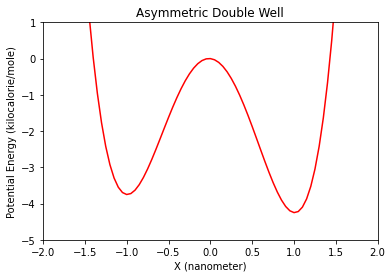

In [4]:
x_serie = np.arange(-2., 2., 0.05) * unit.nanometers
xyz_serie = np.zeros([x_serie.shape[0],3], dtype=float)* unit.nanometers
xyz_serie[:,0] = x_serie

U_x = double_well_asymmetric.potential_energy(xyz_serie)

plt.plot(x_serie, U_x, 'r-')
plt.ylim(-5,1)
plt.xlim(-2,2)
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Potential Energy ({})".format(unit.kilocalories_per_mole))
plt.title("Asymmetric Double Well")
plt.show()

In [5]:
double_well_asymmetric.coordinates_minima()

[Quantity(value=-0.992093989581487, unit=nanometer),
 Quantity(value=1.00772280707545, unit=nanometer)]

In [6]:
double_well_asymmetric.coordinates_maxima()

[Quantity(value=-0.0156288174939649, unit=nanometer)]

In [7]:
double_well_asymmetric.armonic_oscillation_periods()

([Quantity(value=-0.992093989581487, unit=nanometer),
  Quantity(value=1.00772280707545, unit=nanometer)],
 [Quantity(value=4.396332602439496, unit=picosecond),
  Quantity(value=4.2944393987875795, unit=picosecond)],
 [Quantity(value=0, unit=nanometer)],
 [Quantity(value=4.344092140155338, unit=picosecond)])

In [8]:
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = 1.0 * unit.nanometers

initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

time, traj, _, _, _ = langevin_NVT (double_well_asymmetric,
                                    temperature = 300 * unit.kelvin,
                                    friction = 5.0/unit.picoseconds,
                                    initial_positions = initial_positions,
                                    initial_velocities = initial_velocities,
                                    integration_timestep = 0.2 * unit.picoseconds,
                                    saving_timestep = 5.0 * unit.picoseconds,
                                    total_time = 500 * unit.nanoseconds)

100%|██████████| 99999/99999 [01:56<00:00, 858.67it/s] 


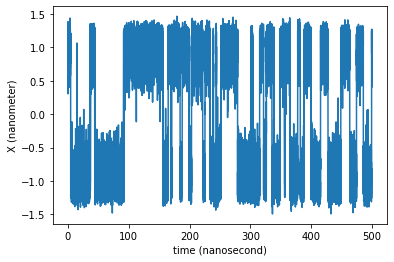

In [9]:
plt.plot(time.in_units_of(unit.nanoseconds), traj[:,0,0])
plt.xlabel('time ({})'.format(unit.nanoseconds))
plt.ylabel('X ({})'.format(traj.unit))
plt.show()

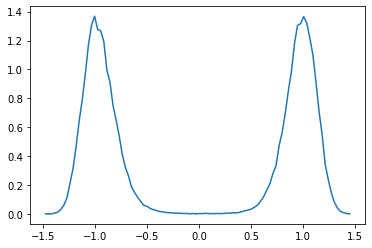

In [10]:
hist, bin_edges = np.histogram(traj[:,0,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

## Discretizing the conformational space

We will consider in this notebook, for the shake of simplicity, that the coordinate space is unidimensional. Thus, the position of the particle is precised by only a float number, its X coordinate. Since we can not work in a continuos space, lets then start defining segments of the conformational space as conformational microstates. At this point the number of microstates or their size will not be a matter of discussion. Lets discretice the interval $[-2.0, 2.0)$ of the X coordinate in 40 bins (with a width of $\Delta x = 0.1 nm$, and lets label each bin with an integer number between 0 and 39 such as the bin $i$ will correspond to the segment $[-2.0+i\Delta x, -2.0+(i+1)\Delta x)$:

In [11]:
lower_limit = -2.0 * unit.nanometers
upper_limit = 2.0 * unit.nanometers
n_bins = 40
delta_x = (upper_limit-lower_limit)/n_bins

In [12]:
delta_x

Quantity(value=0.1, unit=nanometer)

$N$ is the number of microstates

In [13]:
N = n_bins

## Getting the discrete trajectory

Explain the time discretization. T is the number of frames.(t_final - t_initial)/tau

In [14]:
T = traj.shape[0]

In [15]:
n_frames = traj.shape[0]
discrete_traj = np.zeros([n_frames], dtype=int)

for frame_index in range(n_frames):
    bin_index = int(np.floor_divide((traj[frame_index,0,0]-lower_limit)._value, delta_x._value))
    discrete_traj[frame_index]=bin_index

In [16]:
discrete_traj

array([29, 29, 27, ..., 29, 30, 32])

When coding, there is always more than a way to solve a problem. Check that we could had descretized the trajectory also this other two ways:

In [ ]:
discrete_traj = np.floor_divide((traj[:,0,0]-lower_limit)._value, delta_x._value).astype(int)

In [ ]:
discrete_traj

In [ ]:
bin_edges = np.linspace(lower_limit._value, upper_limit._value, n_bins+1, True)
discrete_traj = np.digitize(traj[:,0,0]._value, bin_edges, )-1

In [ ]:
discrete_traj

We already have the trajectory discretized. Each microstate was then labeled with an integer number, thats why the new discretized trajectory looks like an integer array.

## Number of visits or weight of a microstate

Lets call "weight of a microstate" as the number of times the trajectory visited a certain microstate. Lets collect from the trajectory these weights:

In [ ]:
w=np.zeros([n_bins], dtype=int)

for bin_index in discrete_traj:
    w[bin_index]+=1

In [ ]:
w

In [ ]:
np.sum(w>0)

Notice that this could have been solved using numpy or scipy methods as:

In [ ]:
w = np.bincount(discrete_traj, minlength=n_bins)

In [ ]:
w

Or

In [ ]:
w, _ = np.histogram(traj[:,0,0], bins=bin_edges)

In [ ]:
w

In any case, the sum of the weights of all microstates is equal to the number of trajectory frames:

In [ ]:
np.sum(w)

In [ ]:
T

Plotting the weight of each microstate is straightforward:

In [ ]:
plt.bar(range(n_bins), w)
plt.ylabel('Weight')
plt.xlabel('Microstate index')
plt.show()

Using the bins edges we can plot the weights over the coordinate X. This time, instead of drawing steps or bars, lets place the value of the weight in the middle point of each bin:

In [ ]:
bins_mid_point = (bin_edges[1:]+bin_edges[:-1])/2.0
plt.plot(bins_mid_point, w)
plt.ylabel('Weight')
plt.xlabel('X')
plt.show()

## Occupation probability of a microstate

The probability of being the system in a given microstate is obtained dividing its weight by the total number of frames, or the sum of all microstate weights:

In [ ]:
pe = w/w.sum()

In [ ]:
plt.plot(bins_mid_point, pe)
plt.ylabel('Probability')
plt.xlabel('X')
plt.show()

Keep in mind that this former plot shows the occupation probability of each microstate, and not the probability density function of the system in the X coordinate. In other words, this is not the probability of being in any x coordinate, P(x), this is the probability of being in a segment of width $\Delta x$.

## Number of times a transition between microstates is observed along the trajectory or weight of a transition between microstates.

With the microstates defined, a matrix storing the times a transition between microstates is observed along the trajectory can be defined. Lets name this matrix $m$. This way, the value $m_{ij}$ is the number of times the system went from bin $i$ to bin $j$ in a timestep of length $\Delta t$. In this case $\Delta t = 20 ps$,  the same time interval between saved frames.

In [ ]:
W = np.zeros([n_bins, n_bins], dtype=int)

In [ ]:
for frame_index in range(n_frames-1):
    ii = discrete_traj[frame_index]
    jj = discrete_traj[frame_index+1]
    W[jj, ii] += 1

In [ ]:
W

Let's play a bit with the transitions matrix to be familiar with its meaning. For example, we can wonder how many different transitions $i->j$ were observed along the trajectory compared with the total number of possible transitions in the space of discrete microstates.

In [ ]:
n_bins * n_bins # number of possible transitions

In [ ]:
np.sum(W==0) # number of transitions visited at least once

In [ ]:
np.sum(W>0) # number of transitions not observed along the trajectory

Let's see now the number of times a transition was observed from a certain microstate $i$ to any other microstate including itself:

In [ ]:
W[:,25].sum()

And let's see now the number of times a transitions was observed to the same certain microstate $i$ from any other microstate including itself:

In [ ]:
W[25,:].sum()

And lets compare this with the number of times the microstate $i$ was visited along the trajectory:

In [ ]:
w[25]

By construction, it is then true that for almost all $i$:

\begin{equation}
\sum_{j=1}^{N} W_{i,j} = \sum_{j=1}^{N} W_{j,i} = w_{i}
\end{equation}


The first microstate and the last microstate visited in the trajectory may have a hop on, or a hop off, more than the total number of reverse transitions. Again, by construction:

In [ ]:
first_microstate = discrete_traj[0] # First microstate observed in the trajectory

In [ ]:
W[first_microstate,:].sum()-W[:,first_microstate].sum()

In [ ]:
w[first_microstate]-W[:,first_microstate].sum()

And:

In [ ]:
last_microstate = discrete_traj[-1] # First microstate observed in the trajectory

In [ ]:
W[last_microstate,:].sum()-W[:,last_microstate].sum()

In [ ]:
W[:,last_microstate].sum()-w[last_microstate]

The first microstate visited will have a hop on less to balance the number of hops off. The trajectory was already there when we started to count transitions. On the other side the last microstate visited in the trajectory will have a hop off less. The trajectory stopped there. But if the trajectory is long enough this differences will be statistically negligible.

If the trajectory is long enough, and thereby representative of the equilibrium, the number of times a transition $i->j$ is observed should be equal to the number of times the system made the reverse transition $j->i$. And thus the matrix $m$ should be simmetric. But in a real case it does only happen approximately. Actually, a matrix $m$ far from simmetricity could be interpreted as a symptom of having a trajectory  not capturing the equilibrium dynamics of the system.

In [ ]:
W[7,12]

In [ ]:
W[12,7]

Finnally, the weight of each transition out of a certain microstate $i$ to any $j$ can be plot:

In [ ]:
ii=26

plt.bar(range(n_bins), W[:,ii])
plt.ylabel('Weight Transition {} -> j'.format(ii))
plt.xlabel('j index')
plt.show()

Or thanks to the fact that we can assign a representant point to each microstate, the middle point of the bin, we can plot the weigts of the these transitions over the X coordinate. The following figure shows these weights for the transitions out a microstate $i$ together with a vertical red stripe indicating the segment of X where $i$ is defined. In addition, the potential energy landscape is shown with a grey dashed line as reference:

In [ ]:
ii = 26

fig, ax1 = plt.subplots()

ax1.plot(bins_mid_point, W[:,ii])
ax1.axvspan(bin_edges[ii], bin_edges[ii+1], alpha=0.2, color='red')
ax1.set_ylabel('Weight Transition {} -> j'.format(ii))
ax1.set_xlabel('X')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(x_serie, U_x, '--', c='0.5')
ax2.set_ylim(-5,1)
ax2.set_ylabel("Potential Energy ({})".format(unit.kilocalories_per_mole))

fig.tight_layout()
plt.show()

The transition weights can also be represented as a color code matrix:

In [ ]:
plt.matshow(W, cmap='Greys')
plt.show()

## Transition probabilities between microstates

Once the system is in the microstate $i$, the probability of visiting the microstate $j$ after a time interval $\Delta t$ is written as $P_{i,j}(\Delta t)$. $P_{i,j}(\Delta t)$ is called "transition probability" since it is the probability of going from one microstate to another after a certain time period. For each microstate $i$, the sum of all transition probabilities out $i$ is equal to one:

\begin{equation}
\sum_{j=1}^{N} P_{i,j}(\Delta t) = 1
\end{equation}

Once the weights of the transitions have being computed, getting the transition probabilities is straightforward:

\begin{equation}
P_{i,j} = \frac{W_{i,j}}{\sum_{l=1}^{N} W_{i,l}} = \frac{W_{i,j}}{w_{i}}
\end{equation}

Let's the get the transition probabilities from the transition weights stored in matrix $W$:

In [ ]:
P = np.zeros([N,N], dtype=float)

for ii in range(N):
    if W[:,ii].sum()>0:
        P[:,ii] = W[:,ii]/W[:,ii].sum()

This way, by construction:

In [ ]:
P[:,26].sum()

As we did before with the transition weights, we can represent the transition probabilities making use of the middle point of the bin associated to each microstate. The following figure shows the transition probabilities of the microstate $i$ to any other microstate. A red vertical strip indicates the extension of the microstate $i$ along X, and the grey dashed line represents the underlaying potential energy for reference:

In [ ]:
ii = 26

fig, ax1 = plt.subplots()

ax1.plot(bins_mid_point, P[:,ii])
ax1.axvspan(bin_edges[ii], bin_edges[ii+1], alpha=0.2, color='red')
ax1.set_ylabel('Transition Probability {} -> j'.format(ii))
ax1.set_xlabel('X')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(x_serie, U_x, '--', c='0.5')
ax2.set_ylim(-5,1)
ax2.set_ylabel("Potential Energy ({})".format(unit.kilocalories_per_mole))

fig.tight_layout()
plt.show()

The transition probability matrix can also be represented as a 2D plot in grey scale color code:

In [ ]:
plt.matshow(P, cmap='Greys')
plt.show()

## Detailed balance condition on the discrete kinetic model

If the trajectory is large enough, close to capture equilibrium, the number of times the system went from $i$ to $j$ is equal to the number of times the system went from $j$ to $i$ for all microstates $i$ and $j$. This is known us the "detailed balance" condition:

\begin{equation}
W_{j,i} = W_{i,j}
\end{equation}

Which written in terms of the transition probabilities:

\begin{equation}
P_{j,i} w_{i} = P_{i,j} w_{j}
\end{equation}

And writting the number of visits in each microstate using the occupation probability:

\begin{equation}
P_{j,i} p^{e}_{i} T = P_{j,i} p^{e}_{j} T
\end{equation}

Which leaves us with the detalied balance condition written in terms of the occupation and transition probability:

\begin{equation}
P_{j,i} p^{e}_{i} = P_{i,j} p^{e}_{j}
\end{equation}

## The transition probability matrix as a time evolution operator or propagator

In [ ]:
p = np.zeros([N], dtype=float)
p[30] = 1.0

In [ ]:
np.matmul(P,p)

## Kinetic transition network